In [1]:
import gurobipy as gp
from gurobipy import GRB
import math
import matplotlib.pyplot as plt
import numpy as np
import random

In [2]:
# Read the inputs
Start = (50,50) # Depot coordinates
points = [(Start)] #coordinates of all customers
Start_id = 0 # Depot idendifier
new_points = [(17, 72), (97, 8), (32, 15), (63, 97), (57, 60), (83, 48), (100, 26), (12, 62), (3, 49), (55, 77), 
          (97, 98), (0, 89), (57, 34), (92, 29), (75, 13), (40, 3), (2, 3), (83, 69), (1, 48), (87, 27), 
          (54, 92), (3, 67), (28, 97), (56, 63), (70, 29), (44, 29), (86, 28), (97, 58), (37, 2), (53, 71), 
          (82, 12), (23, 80), (92, 37), (15, 95), (42, 92), (91, 64), (54, 64), (85, 24), (38, 36), (75, 63), 
          (64, 50), (75, 4), (61, 31), (95, 51), (53, 85), (22, 46), (70, 89), (99, 86), (94, 47), (11, 56)]

random.seed(76)
sample_points = random.sample(new_points, 25)

points += sample_points

n = len(points) # total number of nodes

# Distance between two cities (i,j)
distance = {(i, j):
        math.sqrt(sum((points[i][k]-points[j][k])**2 for k in range(2)))
        for i in range(n) for j in range(n)}

# Time constraints
early = {46: 0, 50: 0, 8: 12, 1: 22, 32: 39, 23: 53, 34: 69, 12: 91, 22: 109, 9: 111, 19: 156, 17: 191, 29: 194, 16: 209, 3: 227, 26: 236, 39: 255, 41: 274, 6: 292, 36: 300, 28: 308, 44: 312, 49: 322, 33: 333, 27: 337, 38: 340, 20: 346, 14: 354, 7: 373, 2: 388, 31: 399, 42: 408, 15: 425, 25: 434, 43: 439, 13: 456, 40: 466, 18: 490, 48: 502, 11: 530, 47: 541, 4: 551, 21: 563, 35: 576, 45: 584, 10: 591, 30: 598, 37: 600, 24: 603, 5: 615}
late = {46: 35, 50: 41, 8: 53, 1: 63, 32: 80, 23: 94, 34: 110, 12: 132, 22: 150, 9: 152, 19: 197, 17: 232, 29: 235, 16: 250, 3: 268, 26: 277, 39: 296, 41: 315, 6: 333, 36: 341, 28: 349, 44: 353, 49: 363, 33: 374, 27: 378, 38: 381, 20: 387, 14: 395, 7: 414, 2: 429, 31: 440, 42: 449, 15: 466, 25: 475, 43: 480, 13: 497, 40: 507, 18: 531, 48: 543, 11: 571, 47: 582, 4: 592, 21: 604, 35: 617, 45: 625, 10: 632, 30: 639, 37: 641, 24: 644, 5: 656}

for key in late.keys():
    late[key] += 50000 
# Capacity constraints
Q = 10 # the vehicle has a capacity of at most Q
demand = {e: 1 for e in range(1,n)} # each node has a demand of q_i

In [3]:
# Dynamic programming to solve the TSP (see Excercises week 3)
class Label:
    parent = None
    customer= None
    cost = 0.0
    time = 0.0
    load = 0
    distance = 0
    def __init__(self, reward, l = None, node = 0):
        self.customer = node
        if l:
            self.cost = l.cost + distance[(l.customer,node)] - reward[node]
            self.time = resource_extension_T(l, node)
            self.load = resource_Q(l,node)
            self.distance = l.distance + distance[(l.customer,node)]
        self.parent = l
        
# Resource extension
def resource_extension_T(l, node):
    """Return resorces used so far"""
    return max(early[node], l.time + distance[(l.customer,node)])
def resource_Q(l,node):
    return l.load + demand[node]

# Feasibilty check
def feasible(l, i):
    """Returns if extending from label l to node i is feasible"""
    #Is it feasible to go to node i from label l?
    if l.customer == i:
        return False
    if distance[(l.customer,i)] +l.time > late[i]:
        return False
    if l.load + demand[i] > Q:
        return False
    return True
#dominance
def dominance(l1,l2):
    """Retuns true if l1 dominates l2"""
    if l1.cost <= l2.cost:
        if l1.time <= l2.time:
            if l1.load<= l2.load:
                return True
    return False

def labeling_algorithm(reward):
    l0 = Label(reward)
    M = {(k,i): [] for k in range(n) for i in range(n)}
    M[(0,0)].append(l0)
    
    for k in range(1, n): 

        ## k is the number of nodes visited
        for i in range(n):
            
            ## i is the current node
            for j in range(1,n):
                
                ## j is the new node to extend to
                if j == i: 
                    # the new node is different than the current node
                    continue
              
                for l in M[(k-1,i)]:
                    #print("mkij", k,i,j)
                    # l is all the labels stored in this bucket
                    if feasible(l,j):
                        l2 = Label(reward, l, j) #extend label
                        dominated = False
                        for l1 in M[(k,j)]:
                            if dominance(l1, l2):
                                dominated = True
                            elif dominance(l2, l1):
                                ## if l1 is dominated then we need to delete l1
                                M[(k,j)].remove(l1)
                            if dominated:
                                break
                        if not dominated:
                            #if l2 is not dominated add to list of labels
                            M[(k,j)].append(l2)       
    return best_label(M, reward)

def best_label(M={}, reward=None):
    best_l = Label(reward)
    best_cost = 0
    for k in range(1,n):
        for i in range(1,n):
            for l in M[(k,i)]:
                a = distance[(l.customer,Start_id)]
                b = distance[(best_l.customer,Start_id)]
                if l.cost + a < best_l.cost + b:
                    best_l = l
                    best_cost = l.cost + a
    return best_l, best_cost

In [4]:
# compute the total length of a solution
def total_distance(route, distance_matrix):
    if not route[0] == route[-1]:
        route.append(route[0])
    total_dist = 0
    for i in range(1, len(route)):
        total_dist += distance_matrix[route[i-1], route[i]]
    return total_dist

In [5]:
def figure(t):
    ax = plt.gca()
    ax.cla() # clear things for fresh plot

    # change default range so that new circles will work
    ax.set_xlim((-5, 105))
    ax.set_ylim((-5, 105))
    b = []
    a = []
    
    for i in t:
        ax.plot(points[i][1],points[i][0], 'o',color = 'r')
        a = np.append(a, points[i][1])
        b = np.append(b, points[i][0])    
    a = np.append(a, points[t[0]][1])
    b = np.append(b, points[t[0]][0]) 
    ax.plot(a,b)
    for i in points:
        ax.plot(i[1],i[0], 'o',color = 'r')
    for i in t:
        ax.plot(points[i][1],points[i][0], 'o',color = 'r')
    ax.plot(points[0][1],points[0][0], 's', color = 'black')
    
    #plt.plot(a,b)
    
    
    plt.savefig('foo.png')

    plt.show() 

In [6]:
def initialize_master(n):
    # Create a new model
    m = gp.Model("Master Problem")

    # Create variables
    lambda_vars = dict()
    for i in range(1, n):
        lambda_vars[i] = m.addVar(lb=0, ub=1, vtype=GRB.CONTINUOUS, name=f"lambda_vars_{i}")
        
    # Set objective
    m.setObjective(gp.quicksum(distance[0, i] * 2 * lambda_vars[i] for i in range(1, n)), GRB.MINIMIZE)

    # Add constraint that every costumer needs to be visited by at least one vehicle: 
    a = np.eye(n-1)
    visit = dict()
    for i in range(1, n):
        visit[i] = m.addConstr(gp.quicksum(a[i-1, j-1] * lambda_vars[j] for j in range(1, n)) >= 1)

    # Optimize model
    m.setParam("OutputFlag", 0)
    m.optimize()

    # read dual variables of costumer constraints (rewards)
    reward = {i: visit[i].Pi for i in range(1, n)}
    reward[0] = 0
    return m, reward, visit, lambda_vars

In [13]:
# initialize master problem
master, first_reward, visit, lambda_vars = initialize_master(n)

iteration = 0
reward = first_reward
red_cost = -100000
tours = dict()

# while there exist positive reduced costs, generate new columns
while red_cost < -1e-13:
    iteration += 1
    if iteration % 10 == 0:
        print(f"iteration = {iteration}, reduced costs = {red_cost}")
    l, red_cost = labeling_algorithm(reward)
    
    # generate tour
    tour = []
    while l.parent:
        tour.append(l.customer)
        l = l.parent
    tour.append(Start_id)
    tour.reverse()
    tour.append(Start_id)
    tours[iteration] = tour
    tour_length = total_distance(tour, distance)
    
    # create new column a[:, r] for the new found route
    new_col = [tour.count(customer) for customer in range(1, n)]
    
    # add new variable to master problem
    lambda_vars[(n-1) + iteration] = master.addVar(lb=0, 
                                           ub=1, 
                                           obj=tour_length,  # add it to objective 
                                           vtype=GRB.CONTINUOUS, 
                                           name=f"lambda_vars_{(n-1) + iteration}")

    # update customer constraints:
    for i in range(1, n):
        master.chgCoeff(visit[i], lambda_vars[(n-1) + iteration], new_col[i-1])
    
    # resolve master problem
    master.optimize()
    if iteration % 10 == 0:
        print("obj function = ", master.ObjVal)

    # read dual variables of costumer constraints (rewards)
    reward = {i: visit[i].Pi for i in range(1, n)}
print(f"final reduced costs = {red_cost}")
print("final relaxed obj function = ", master.ObjVal)

iteration = 10, reduced costs = -274.3292999425091
obj function =  653.9282885221436
iteration = 20, reduced costs = -154.7116042745942
obj function =  614.5183009684749
iteration = 30, reduced costs = -130.4979917101524
obj function =  566.4005556545142
iteration = 40, reduced costs = -108.14536431750184
obj function =  553.8259365959136
iteration = 50, reduced costs = -100.17131696471222
obj function =  534.6129114938316
iteration = 60, reduced costs = -58.67354194887076
obj function =  515.0235619055653
iteration = 70, reduced costs = -84.25444935584524
obj function =  493.6027007780757
iteration = 80, reduced costs = -69.48805524793585
obj function =  479.72614583133304
iteration = 90, reduced costs = -89.89653579453574
obj function =  474.67100607890904
iteration = 100, reduced costs = -52.44012219162528
obj function =  468.5987726518884
iteration = 110, reduced costs = -34.44227728233626
obj function =  464.66561868787284
iteration = 120, reduced costs = -25.693361810313537
obj f

In [14]:
# change the variables to be binary
for i in range(1, n):
    lambda_vars[i].vtype = GRB.BINARY
for i in range((n-1) + 1, (n-1) + iteration):
    lambda_vars[i].vtype = GRB.BINARY
    
# resolve master problem
master.optimize()
print("final MILP obj function = ", master.ObjVal)

final MILP obj function =  496.752667374182


In [15]:
final_route = [0]
for i in range(1, n):
    if lambda_vars[i].x == 1: 
        final_route += [i, 0]
for i in range(1, iteration+1):
    if lambda_vars[(n-1) + i].x >= 1-(1e-2): 
        final_route += tours[i][1:]

In [16]:
np.array(final_route)

array([ 0, 10,  9, 15, 20, 12, 24,  6, 19,  2,  1,  0,  4,  3,  7,  5, 17,
       13, 23,  8, 11, 25,  0, 16, 18, 14, 21, 22,  5,  7, 17,  3,  4,  0])

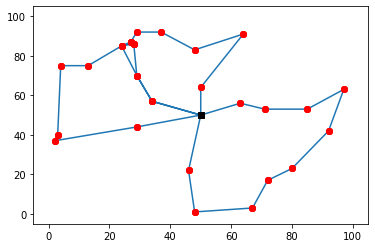

In [17]:
figure(final_route)

In [12]:
# Feasibilty check
def feasible(l, i):
    """Returns if extending from label l to node i is feasible"""
    #Is it feasible to go to node i from label l?
    if l.customer == i:
        return False
    if distance[(l.customer,i)] +l.time > late[i]:
        return False
    if l.load + demand[i] > Q:
        return False
    p = l.parent
    while p is not None:
        if p.customer == i:
            return False
        else:
            p = p.parent
    return True